In [5]:
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import Audio
import warnings 
warnings.filterwarnings('ignore')

In [6]:
print("TensorFlow version :", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version : 2.9.1
Num GPUs Available:  0


In [7]:
train_dir = r'C:\Users\Anas\Downloads\ML\train'
test_dir = r'C:\Users\Anas\Downloads\ML\test'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path +"/" +expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


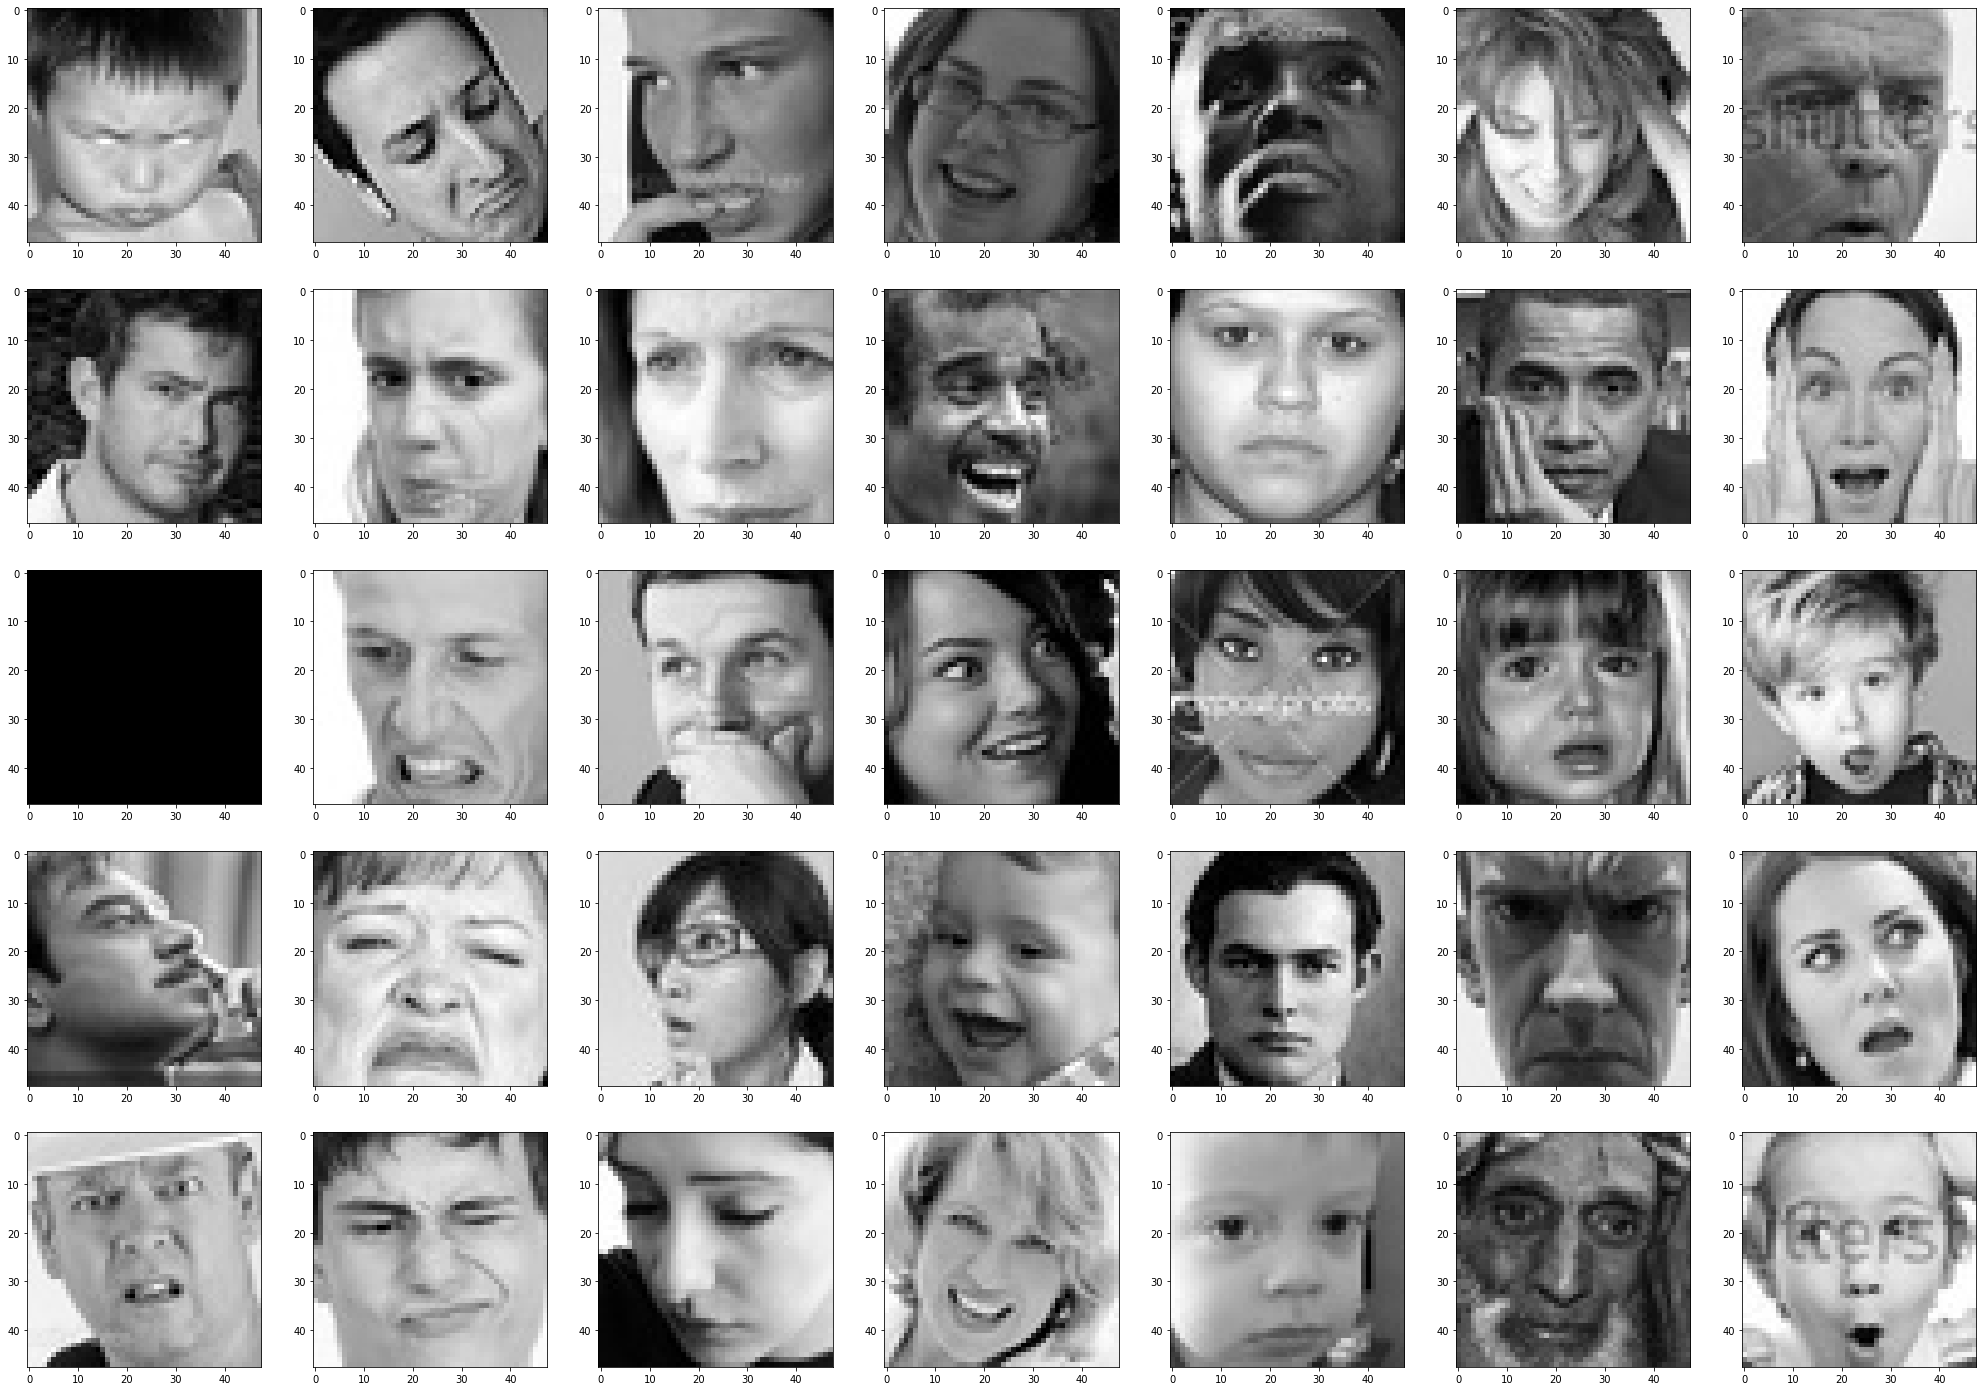

In [8]:
from skimage.io import imread
train_dir = "C:\\Users\\Anas\\Downloads\\ML\\train\\"
test_dir = "C:\\Users\\Anas\\Downloads\\ML\\test"
total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))
for x in range(5):
    for y,v in zip(range(total_labels),os.listdir(train_dir)):
        ax[x][y].imshow(imread(train_dir+v+'/'+os.listdir(train_dir+v)[x]), cmap='gray')

plt.show()

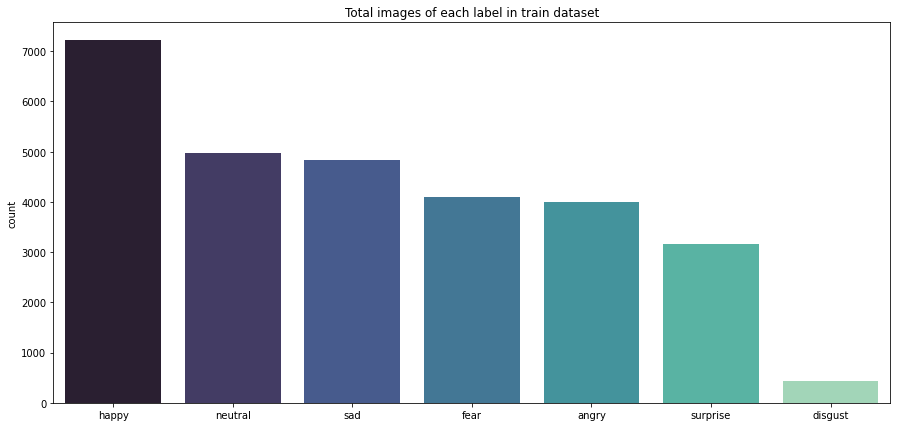

In [9]:
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(15,7))
sns.barplot(x=df.index, y="total", palette="mako", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()

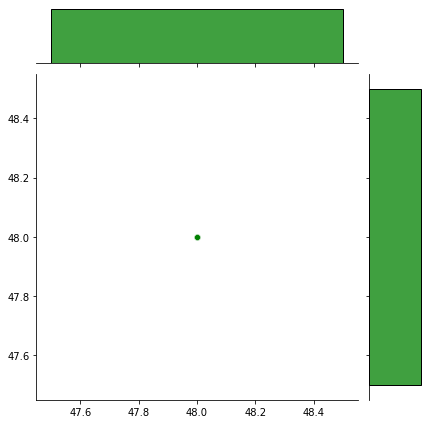

In [10]:
happy = os.listdir(train_dir+'happy/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'happy/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)
sns.jointplot(dim1, dim2,color='g')
plt.show()

In [11]:
train_gen = ImageDataGenerator(rescale=1/255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,
                               zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

train_generator = train_gen.flow_from_directory(directory=train_dir, target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',batch_size=64,class_mode='categorical',shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,target_size=(img_shape[0], img_shape[1]),color_mode='grayscale',
                                                batch_size=64,class_mode='categorical',shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [12]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 5

history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,
                    #callbacks=callbacks,
                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/5
448/448 [==============================] - 1732s 4s/step - loss: 1.8752 - accuracy: 0.2283 - val_loss: 2.7380 - val_accuracy: 0.1878
Epoch 2/5
448/448 [==============================] - 1687s 4s/step - loss: 1.8034 - accuracy: 0.2431 - val_loss: 1.8440 - val_accuracy: 0.2616
Epoch 3/5
448/448 [==============================] - 1692s 4s/step - loss: 1.7878 - accuracy: 0.2504 - val_loss: 1.7902 - val_accuracy: 0.2722
Epoch 4/5
448/448 [==============================] - 1688s 4s/step - loss: 1.7793 - accuracy: 0.2571 - val_loss: 1.7847 - val_accuracy: 0.2755
Epoch 5/5
448/448 [==============================] - 1693s 4s/step - loss: 1.7645 - accuracy: 0.2717 - val_loss: 1.6922 - val_accuracy: 0.3122


In [15]:
model.save("model.h5")

In [16]:
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

113/113 [==============================] - 123s 1s/step - loss: 1.6920 - accuracy: 0.3126
validation accuracy : 31.262189149856567%
validation loss : 1.692007303237915


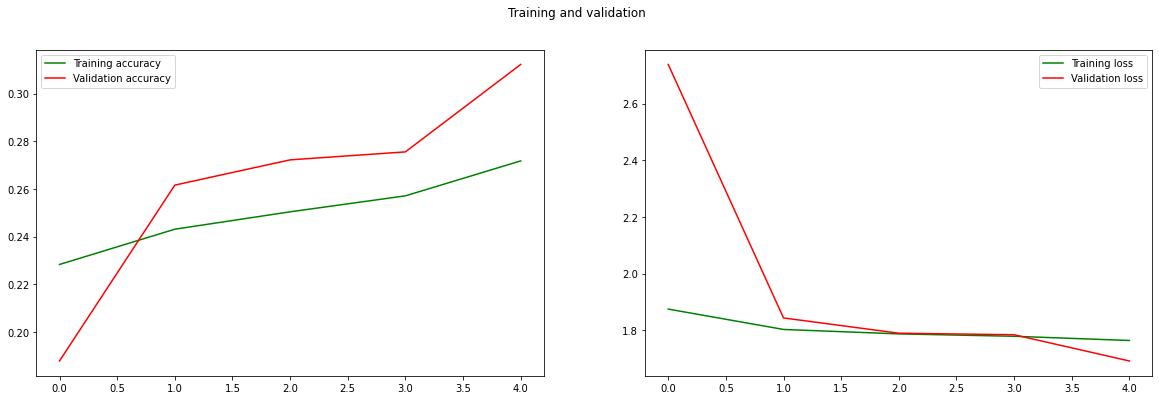

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'g', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'g', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

113/113 [==============================] - 217s 2s/step
              precision    recall  f1-score   support

       angry       0.24      0.03      0.05       958
     disgust       0.00      0.00      0.00       111
        fear       0.25      0.00      0.01      1024
       happy       0.31      0.77      0.44      1774
     neutral       0.31      0.22      0.26      1233
         sad       0.27      0.06      0.10      1247
    surprise       0.34      0.60      0.44       831

    accuracy                           0.31      7178
   macro avg       0.25      0.24      0.19      7178
weighted avg       0.28      0.31      0.23      7178





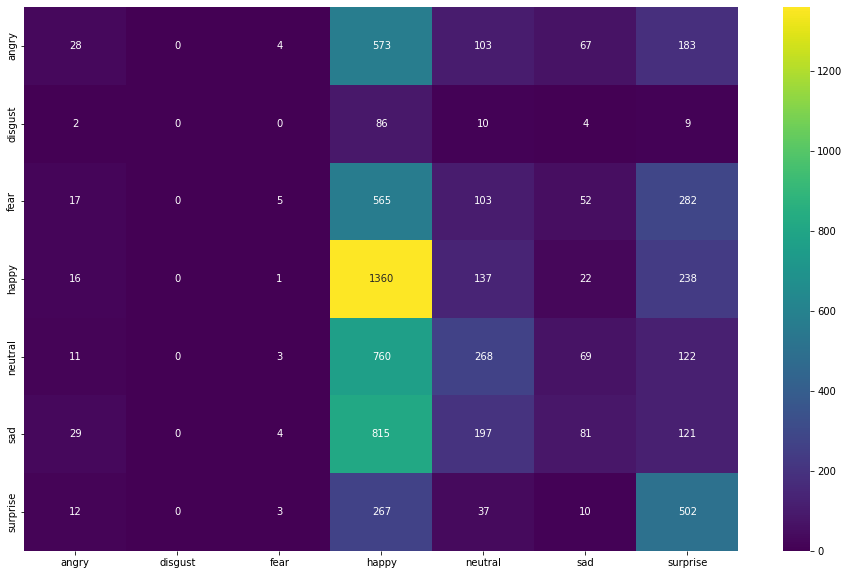

In [18]:
# confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.viridis, annot=True, fmt='.0f', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

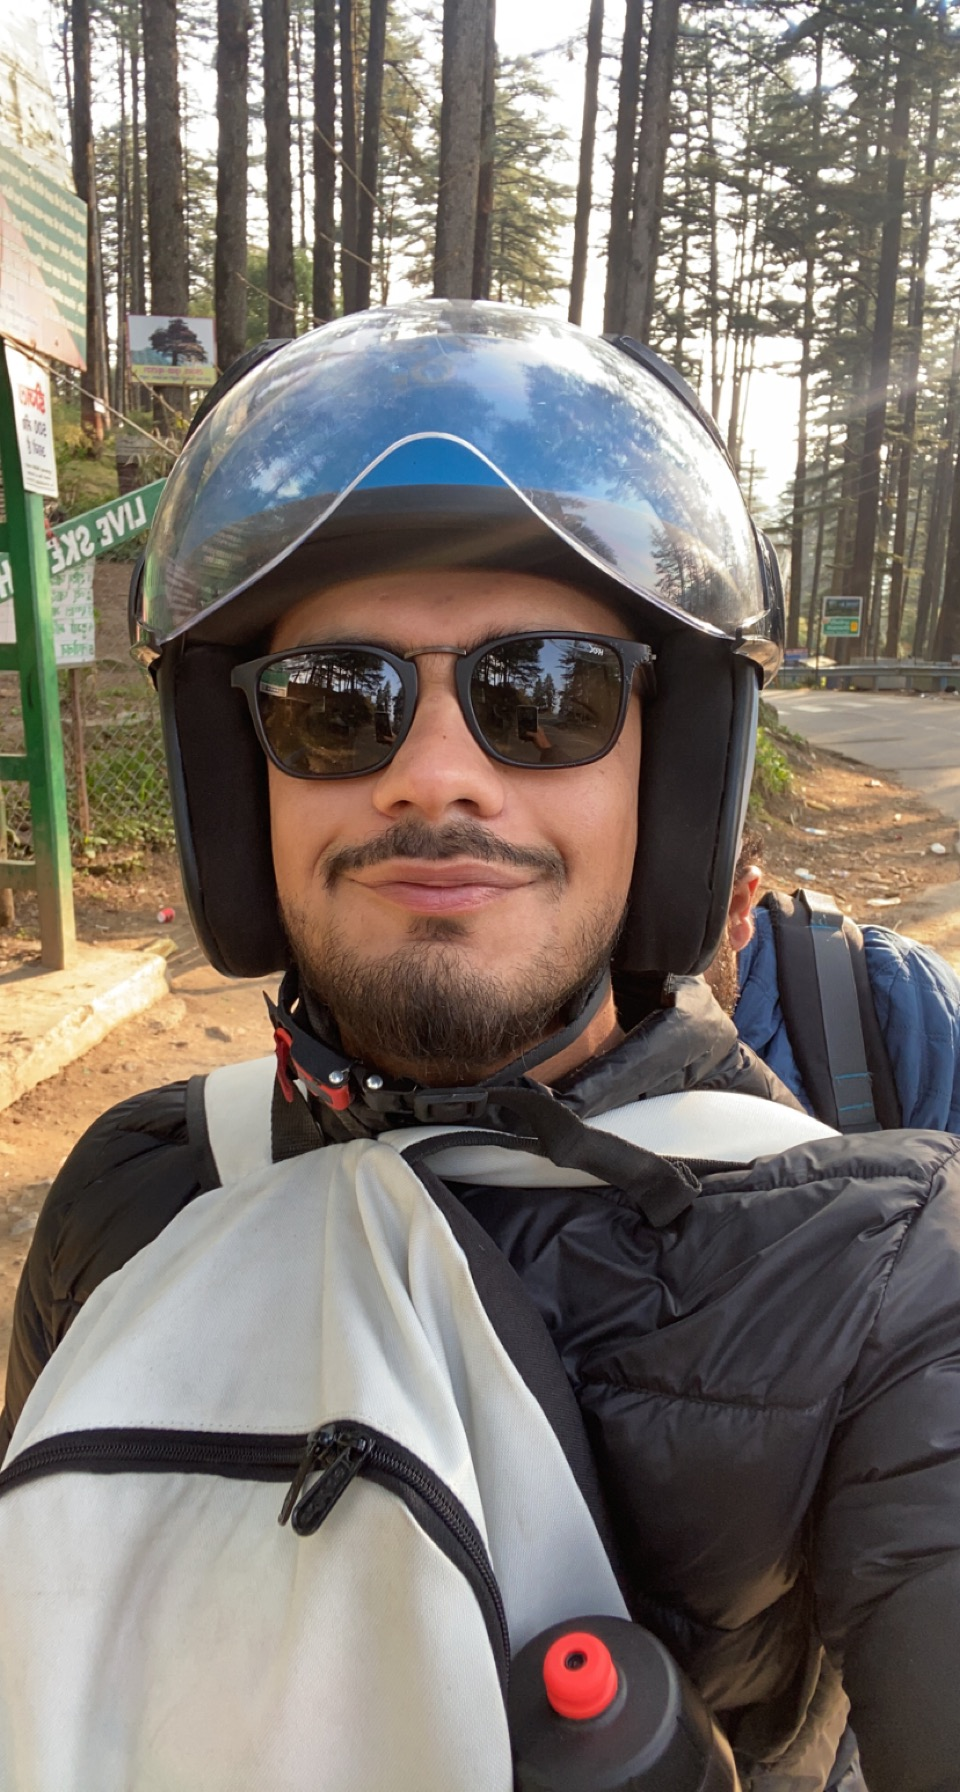

In [20]:
image = cv2.imread("C:\\Users\\Anas\\Downloads\\Anas.jpg")
from IPython.display import Image
Image(filename='C:\\Users\\Anas\\Downloads\\Anas.jpg')

In [21]:
import cv2
from tensorflow.python.keras.models import load_model
import os


# # load the trained model

model = tf.keras.models.load_model("model.h5",
    custom_objects={'Functional':tf.keras.models.Model})
# A list of emoticon categories
EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']
# Load image
img = image

# Trim the image to 48 x 48, and turn the grayscale image, normalization
frame = cv2.resize(img,(48,48),interpolation=cv2.INTER_BITS2)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

# Reinvent the image dimension
gray = gray.reshape(1,48,48,1)

# Output the prediction
predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i,j) in zip(range(7),EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j)+"prediction rate is   {0:.2f}%".format(predictss))
print( "\n\n The system considers this expression to be:",label)

1/1 [==============================] - 1s 941ms/step
  Angry   prediction rate is   0.19%
 Disgust  prediction rate is   0.00%
  Happy   prediction rate is   0.16%
   Sad    prediction rate is   0.25%
 Surprise prediction rate is   0.10%
 Neutral  prediction rate is   0.20%


 The system considers this expression to be: Sad


In [22]:
if (label=='Angry'):
    path="C:\\Users\\Anas\\Downloads\\song\\Angry\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='C:\\Users\\Anas\\Downloads\\song\\Angry\\'+ d,autoplay=True)
    display(audio)
elif (label=='Disgust'):
    path="C:\\Users\\Anas\\Downloads\\song\\Disgust\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='C:\\Users\\Anas\\Downloads\\song\\Disgust\\'+ d,autoplay=True)
    display(audio)    
elif (label=='Happy'):
    path="C:\\Users\\Anas\\Downloads\\song\\Happy\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='C:\\Users\\Anas\\Downloads\\song\\Happy\\'+ d,autoplay=True)
    display(audio)        
elif (label=='Sad'):
    path="C:\\Users\\Anas\\Downloads\\song\\Sad\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='C:\\Users\\Anas\\Downloads\\song\\Sad\\'+ d,autoplay=True)
    display(audio)        
elif (label=='Surprise'):
    path="C:\\Users\\Anas\\Downloads\\song\\Surprise\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='C:\\Users\\Anas\\Downloads\\song\\Surprise\\'+ d,autoplay=True)
    display(audio)        
elif (label=='Nuetral'):
    path="C:\\Users\\Anas\\Downloads\\song\\Nuetral\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='C:\\Users\\Anas\\Downloads\\song\\Neutral\\'+ d,autoplay=True)
    display(audio)    

Now Playing: Arijit Singh - Dhokha_64(PagalWorld.com.se).mp3
